<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P3.1_rnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchtext
!pip install torchdata

In [ ]:
import torch
import torchtext
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# P3.1 - Sequence classification: Predicting news article genres

In this tutorial, we provide an example of text classification using the AG News dataset. The dataset contains 120.000 datapoints for training and 7600 datapoints for testing. Each datapoint is an input news article (given as a sequence of words $X:\{x_{0:n}\}$) and a label ($Y$) which encodes the article's genre with a class id (integer). More specifically, the class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech. Our goal is to train a model that predicts the genre of an input news article.

### Loading dataset

The torchtext library provides a few dataset iterators, which yield the raw text strings. For example, the ``AG_NEWS`` dataset iterators yield the raw data as a tuple of label $(Y)$ and text $(X)$. Here we load the train and test iterators and print a few examples.

In [ ]:
from torchtext.datasets import AG_NEWS

train_iter, test_iter = AG_NEWS(split=('train', 'test'))
train_data = list(train_iter)
test_data = list(test_iter)

print(f"Number of training news articles: {len(train_data)}")
print(f"Number of testing news articles: {len(test_data)}\n\n")

classdict = {1:"world", 2:"sports", 3:"business", 4:'sci/tech'}

for i in range(3):
    y, x = test_data[i]
    print("X: " + x)
    print("Y: " + classdict[y] + '\n')

Number of training news articles: 120000
Number of testing news articles: 7600


X: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Y: business

X: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Y: sci/tech

X: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
Y: sci/tech



# Preprocessing textual input data

### Create vocabulary
As we have seen in practical P1.2, word embeddings are useful for encoding words into dense vectors of real numbers.  The first step is to build a custom vocabulary from the raw training dataset. To this end, we tokenize each article, i.e. transform the full article in string format into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. Note that there is a subtle difference between tokens and words. For example, "good" and "morning" are both words and tokens, but "!" is a token, not a word.

When all sentences are tokenized we proceed with counting the number of occurances of each token in each of the articles using `counter`. Finally, we create the vocabulary by using the frequencies of each token in the counter. 

In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab

tokenizer = get_tokenizer('basic_english')

counter = Counter()

for (label, article) in tqdm(train_data):
    counter.update(tokenizer(article))

for (label, article) in tqdm(test_data):
    counter.update(tokenizer(article))
    
vocab = vocab(counter, min_freq=1)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

The tokenizer preprocesses an input sentence. More specifically, it normalizers converts all characters to lowercase and splits the sentence into a list of words and punctuation marks. For example:

    tokenizer("You can now install TorchText using pip!")
    >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


The vocabulary allows us to convert a list of tokens into integers:

    [vocab[token] for token in ['here', 'is', 'an', 'example']]
    >>> [879, 179, 92, 2521]

### Create text and label 

We employ the tokenizer and vocabulary to process the raw data strings from the dataset iterators. The `text_pipeline` converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the class label (=genre) into an integer. 

In [ ]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x) - 1

For example:

    text_pipeline('here is the an example')
    >>> [475, 21, 2, 30, 5286]
    label_pipeline('10')
    >>> 9

### Generate batch iterators

We use `torch.utils.data.DataLoader` for creating an input pipeline that processes both the textual input data and labels to make them compatible with a PyTorch model. Additionally, the `DataLoader` provides extra functionalities that are useful in many deep-learning projects (e.g. batching, shuffling and many more). We shall specify how the data points need to be batched using the `collate_fn` method that can be passed as input argument to `DataLoader`. The input of the ``collate_fn`` function is list of $k$ datapoints where $k$ denotes the batch size that was passed in ``DataLoader``. The ``collate_fn`` function then processes each of these $k$ datapoints according to the data processing pipelines declared previously, i.e. by employing the vocabulary, text pipeline and label pipeline.

Note that the number of words in each article is not nessarily the same. This often causes difficulties when batching multiple datapoints. To solve this issue, we will zero-pad the sequences, i.e. append zeros such that all sequences have the same length. 

**Tip:** Ideally, we do not want these zero-padded words to be processed by our rnn since the padded words do not hold any additional information. PyTorch provides functionality for converting input sequences to a memory and computational efficient format by packing all padded sequences, see [stackoverflow](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch). 

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    
    label_list, text_list, text_length = [], [], []
    
    # iterate over each sample in the batch
    for (_label, _text) in batch:
              
        # process label using the label_pipeline and 
        # append this processed label to a list
        label_list.append(label_pipeline(_label))
        
        # process the input text using the text_pipeline
        # and append this processed text to a list
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        
        # count the number of words in this datapoint
        # why we need this will become clear in a moment..
        text_length.append(processed_text.size(0))
        
    # convert label_lists to torch.tensor that is compatible with pytorch
    label_batch = torch.tensor(label_list, dtype=torch.int64)
    text_length = torch.tensor(text_length, dtype=torch.int64)
    
    # add zeros to ensure that all sequences have same length
    padded_text_batch = pad_sequence(sequences = text_list, 
                                    batch_first=True, 
                                    padding_value=0.0)
    
    # return labels and articles after transferring them to GPU (if available)
    return label_batch.to(device), padded_text_batch.to(device)


train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, collate_fn=collate_batch)

It is often useful to have access to a single batch of data. For instance, in the model development stage we want to feed a single batch to our model and check if the code runs without errors and bugs. We can extract a single batch from the `DataLoader` in the following way:
    
    >>> y_batch, x_batch = next(iter(dataloader))
    

Furthermore, we can retrieve the whole dataset in batches by iterating over the `DataLoader`, i.e.

    >>> for batch_idx, (y_batch, x_batch) in enumerate(dataloader):
            pass
    
    


# Define, train and evaluate the recurrent classification model

We employ a long-short-term memory (LSTM) cell that processes each of the words (embeddings) of news articles. The first layer is the Embedding layer that uses a vector with `embed_dim=500` entries representing each word. The next layer is the LSTM layer with 128 neurons representing the hidden state of the LSTM. By default, PyTorch's LSTM initiates hidden state and cell state of zeros and automatically updates the these state after seeing the word embedding of each token in the sequence. If trained properly, the hidden state of the last timestep (i.e. when all tokens in an article have passed) contains all information that is required to predict the article's genre. Finally, via two dense layers (with ReLU nonlinearity inbetween) we map the information of this final hidden state to a vector of length `num_class=4`. The class (i.e. which genre) is obtained by the `torch.argmax` operation. Alternatively, one could assign probabilities to each class through the a softmax activation function after the final dense layer. Similarly, the predicted class is then obtained by checking which class has the highest probability. 

In [ ]:
from torch import nn

class RNNClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, n_layers, hidden_dim, num_class):
        super(RNNClassificationModel, self).__init__()
        
        # save some parameters
        self.n_layers = n_layers
        self.embed_dim = embed_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, text):
        
        # input shapes:
        # text: [batch_size, max. sequence length in batch]
        
        
        # embed sequences with word embedding
        # shape [batch_size, max. sequence length in batch, embed_dim]
        h = self.word_embeddings(text)    
    
        # Feed packed input sequence to lstm 
        out, (hidden, _) = self.rnn(h)
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        last_timestep = out[:,-1]
        
        # apply dropout
        last_timestep = self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = self.drop(self.fc1(last_timestep))
        h = nn.ReLU()(h)
        
        # shape [batch_size, num_classes]
        y_pred = self.fc2(h)
    
        return y_pred

In [ ]:
import time
from torch.nn.functional import softmax

def train(dataloader):
    
    model.train()
    
    total_acc, total_count = 0, 0
    start_time = time.time()
    for (y_true, text_batch) in tqdm(dataloader):
        
        model.optimizer.zero_grad()
        
        y_pred = model(text_batch) #shape (batch_size, num_classes) 

        y_class = y_pred.argmax(dim=-1) 
        
#         y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
        
        loss = model.criterion(y_pred, y_true)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        model.optimizer.step()
        
        
        
        total_acc += (y_class == y_true).sum().item()
        total_count += y_true.size(0)
        
  
            
    return total_acc/total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (y_true, text_batch) in enumerate(dataloader):
            
            y_pred = model(text_batch) #shape (batch_size, num_classes) 
            
            y_class = y_pred.argmax(dim=-1) 
            
#             y_prob = softmax(y_pred, dim=-1)  #alternatively, one can assign probabilities to each class with softmax activation
            
            loss = model.criterion(y_pred, y_true)
            
            total_acc += (y_class == y_true).sum().item()
            total_count += y_true.size(0)

    return total_acc/total_count

### Combine everything, train and evaluate model

In [ ]:
# hyperparameters
EPOCHS = 10 # epoch
BATCH_SIZE = 256 # batch size for training/validation


# initiate recurrent classification model
model = RNNClassificationModel(len(vocab), 
                               embed_dim=500, 
                               n_layers = 1, 
                               hidden_dim=128, 
                               num_class=4).to(device)



# training loop
train_loss, val_loss = [], []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    
    train_loss.append(train(train_dataloader))
    val_loss.append(evaluate(test_dataloader))
    
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           val_loss[-1]))
    print('-' * 59)



  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time: 30.19s | valid accuracy    0.252 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time: 30.26s | valid accuracy    0.252 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time: 30.06s | valid accuracy    0.504 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time: 30.14s | valid accuracy    0.674 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time: 30.29s | valid accuracy    0.834 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time: 30.37s | valid accuracy    0.882 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time: 30.48s | valid accuracy    0.895 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time: 30.28s | valid accuracy    0.899 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time: 30.42s | valid accuracy    0.899 
-----------------------------------------------------------


  0%|          | 0/469 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time: 30.50s | valid accuracy    0.895 
-----------------------------------------------------------


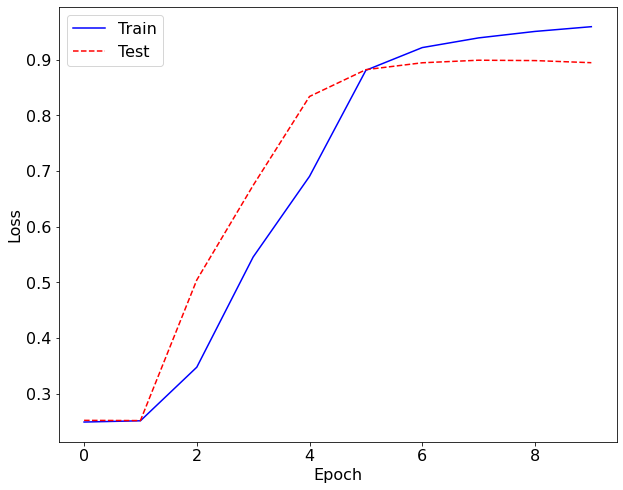

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,8))

fnt=16
ax.plot(train_loss, color='blue', label='Train')
ax.plot(val_loss, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);


### Confusion matrix

For classification tasks it is often instructive to look at the confusion matrix. This clearly shows which kind of errors are frequent. For instance, we see that class 2 (business) and 3 (sci-tech) are often confused.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


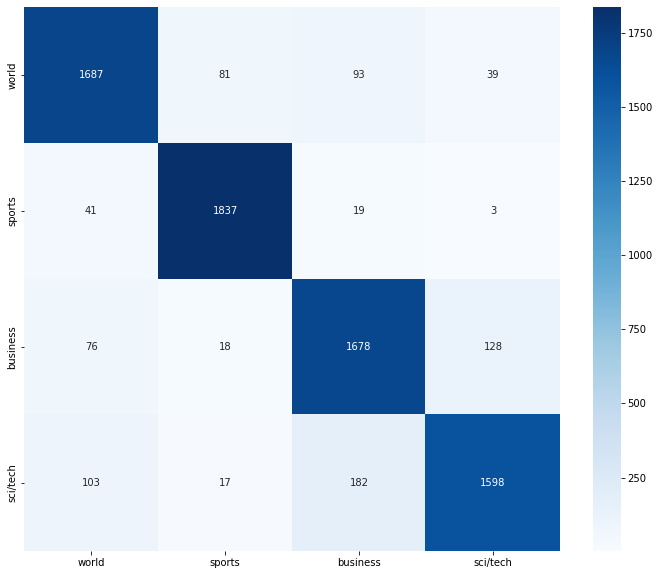

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
%pylab inline


test_iter = AG_NEWS(split='test')
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_batch)


# predict in batches the classes of all samples in test dataset 
y_pred, y_true = [], []
for idx, (y, text_batch) in enumerate(test_dataloader):
    
    y_pred.append(model(text_batch).argmax(1))
    y_true.append(y)

# plot confusion matrix

y_true_np = torch.cat(y_true).cpu().numpy()
y_pred_np = torch.cat(y_pred).cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)
f, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d", xticklabels=classdict.values(), yticklabels=classdict.values())